# Model building

In [260]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import os
import sys
limit = None


def clean3(zippath, filenames):
    
    # amino-acid letters
    aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
    
    # files to dataframe
    with ZipFile(zippath, 'r').open(filenames[0]) as file1:
        df_seq = pd.read_csv(file1)        
    with ZipFile(zippath, 'r').open(filenames[1]) as file2:
        df_dup = pd.read_csv(file2)
    
    # merge the dataframes
    df_merge = df_dup.merge(df_seq,how='inner',on='structureId')
    df_merge.rename({'macromoleculeType_x':'macromoleculeType',
                                            'residueCount_y':'residueCount'},axis=1,inplace=True)
    
    # clean the columns
    df_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)
    df_merge_protein = df_merge[df_merge.macromoleculeType=='Protein']
    df_merge_proteins = df_merge_protein[df_merge_protein.chainId=='A']
    df_merge_proteins2 = df_merge_proteins.drop([
                         'experimentalTechnique',
                         'chainId',
                         'residueCount',
                         'macromoleculeType',
                         'crystallizationMethod',
                         'crystallizationTempK',
                         'densityMatthews',
                         'densityPercentSol',
                         'pdbxDetails',
#                          'phValue',
                         'publicationYear',
                         'resolution'], axis=1)
    
    
    # drop na
    df_merge_proteins3 = df_merge_proteins2.dropna()
    
    # to identify the top 10 classes
    tab = df_merge_proteins2.classification.value_counts(normalize=True)
    filtered_classes = list(tab.keys()[:10])
    df_merge_proteins4 = df_merge_proteins3[df_merge_proteins3.classification.isin(filtered_classes)]
    
    # to delete unreadable amino-acid letters
    mask = df_merge_proteins4.sequence.apply(lambda x: set(x) <= set(aa))
    df_masked = df_merge_proteins4[mask]
    
    # cleansed sequences to list
    sequences = df_masked.sequence.tolist()
    
    # indexes
    indexes = df_masked.structureId
#     return sequences, indexes
    return df_masked


def variance_data(pca):
        # Calculate the explained variance
        exp_var = [i*100 for i in pca.explained_variance_ratio_]

        # Calculate the cumulative variance
        cum_var = np.cumsum(pca.explained_variance_ratio_*100)

        # Combine both in a data frame
        pca_var = pd.DataFrame(data={'Explained Var': exp_var,
                                     'Cumulative Var': cum_var})
        print(pca_var)
        
        # display both the explained and cumulative variance
        fig = plt.figure(figsize=(10,7))

        ax = sns.barplot(
                x = pca_var.index, 
                y = 'Explained Var',  data = pca_var )
        ax.set(
                xlabel = 'Principal Components', 
                ylabel = 'Explained Variance' )

        fig = plt.figure(figsize=(10,7))

        ax = sns.barplot(
                x = pca_var.index, 
                y = 'Cumulative Var',  data = pca_var )
        ax.set(
                xlabel = 'Principal Components', 
                ylabel = 'Cumulative Variance' )
        


### base dataframe to work on

In [10]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

print(df_ML.shape)

print(df_ML.isnull().sum().value_counts())

print(df_ML.columns[:4])

Index(['structureId', 'classification', 'structureMolecularWeight', 'phValue'], dtype='object')

### to save an additional version

In [11]:
df_ML1 = df_ML.drop(['sequence','classification'], axis=1)

df_ML2 = df_ML1.set_index('structureId')

df_ML2.to_csv('kaggle_dataset_for_ML.csv')

### suport vector regressor for pH regression

In [3]:
df_towork = pd.read_csv('kaggle_dataset_for_ML.csv', index_col='structureId')

y = df_towork.phValue
X = df_towork.drop('phValue',axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LinearRegression()
svr = SVR(kernel='poly', verbose=True)
# lr.fit(Xtrain, ytrain)
# ypred = lr.predict(Xtest)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)

print(r2_score(ytest, ypred))


# final = pd.DataFrame()
final = pd.DataFrame(ypred, columns=['pred'])
# final['pred'] = pd.DataFrame(ytest)

final['test'] = pd.DataFrame(ytest).reset_index().phValue

print(final.describe())

plt.scatter(final.test,final.pred)

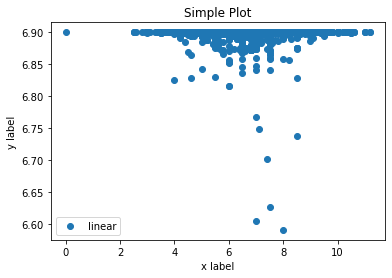

In [256]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.scatter(final.test,final.pred, label='linear')  # Plot some data on the axes.
# ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
# ax.plot(x, x**3, label='cubic')  # ... and some more.
# ax.set_ylim(6.8975,6.9025)
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

## PCA on df_towork

In [122]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_towork),
                           columns=df_towork.columns)


pca = PCA()
ylabel = 'phValue'
pca.fit(scaled_data.drop('phValue',axis=1))
W = pca.components_    
pca_df = pd.DataFrame(
    pca.fit_transform(scaled_data.drop('phValue',axis=1)),
    columns = ['PC'+str(i+1) for i in range(scaled_data.drop('phValue',axis=1).shape[1])], 
    index   = scaled_data.drop('phValue',axis=1).index)

X = pca_df.iloc[:,:10]
y = scaled_data.phValue

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LinearRegression()
svr = SVR(kernel='poly', verbose=True)
# lr.fit(Xtrain, ytrain)
# ypred = lr.predict(Xtest)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)

print(r2_score(ytest, ypred))
# plt.scatter(ypred,ytest)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.scatter(ypred,ytest, label='linear')  # Plot some data on the axes.
# ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
# ax.plot(x, x**3, label='cubic')  # ... and some more.
ax.set_xlim(-2,2)
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

variance_data(pca)

,structureMolecularWeight,phValue,MoreauBrotoAuto_ResidueASA27,MoreauBrotoAuto_ResidueASA26,MoreauBrotoAuto_ResidueASA25,MoreauBrotoAuto_ResidueASA24,MoreauBrotoAuto_ResidueASA23,MoreauBrotoAuto_ResidueASA22,MoreauBrotoAuto_ResidueASA21,MoreauBrotoAuto_ResidueASA20,...,GearyAuto_Steric19,GearyAuto_Steric18,GearyAuto_Steric13,GearyAuto_Steric12,GearyAuto_Steric11,GearyAuto_Steric10,GearyAuto_Steric17,GearyAuto_Steric16,GearyAuto_Steric15,GearyAuto_Steric14
0,-0.213679,-0.605854,-1.323777,-0.858152,0.470030,0.348676,0.295320,-0.229185,-0.173303,0.224859,...,-1.454737,-0.093638,-1.429818,-1.423566,-1.472925,-1.429434,-1.468413,-1.493208,-1.569407,-1.505270
1,-0.562984,-1.551871,1.645859,2.177321,-0.045601,2.074418,2.090322,0.761087,0.704799,2.190561,...,-0.062551,0.710736,-0.009650,0.000344,-0.001949,-0.002725,-0.055261,-0.059326,-0.001440,-0.010767
2,-0.546801,-1.551871,1.645859,2.177321,-0.045601,2.074418,2.090322,0.761087,0.704799,2.190561,...,-0.062551,0.710736,-0.009650,0.000344,-0.001949,-0.002725,-0.055261,-0.059326,-0.001440,-0.010767
3,-0.374789,-0.290516,-1.207775,-1.383522,-0.955537,-0.596730,-0.504135,0.516911,0.526435,-0.430375,...,0.071867,-0.871639,0.047156,0.038570,0.046438,0.053965,0.089926,0.046531,0.065896,0.057165
4,-0.386472,-0.132846,-1.207775,-1.383522,-0.955537,-0.596730,-0.504135,0.516911,0.526435,-0.430375,...,0.071867,-0.871639,0.047156,0.038570,0.046438,0.053965,0.089926,0.046531,0.065896,0.057165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55862,-0.221065,0.576666,-0.720569,-1.529458,0.106055,0.783863,0.853430,-0.283447,-0.296786,0.849617,...,-0.571419,1.950264,-0.549314,-0.611268,-0.640663,-0.616871,-0.577933,-0.569365,-0.568986,-0.573632
55863,-0.380552,-0.605854,-1.196175,-1.179212,-0.970702,-0.476679,-0.368379,0.544041,0.540155,-0.308471,...,0.119874,-0.884825,0.094495,0.086352,0.094825,0.101207,0.138322,0.085024,0.104374,0.105688
55864,-0.671159,1.365013,-0.790170,-1.689988,-1.122358,-0.761801,-0.519219,-1.829900,-1.751141,-0.399899,...,-0.648229,0.341516,-0.643992,-0.697276,-0.698727,-0.654665,-0.645687,-0.636728,-0.626703,-0.602746
55865,-0.412323,0.182493,0.021839,1.068206,-0.394409,-0.056498,0.023807,0.964568,0.979206,0.118193,...,-0.196969,0.315143,-0.227409,-0.353244,-0.098724,0.157898,-0.190768,-0.184430,-0.193829,-0.204858


## Logistic regression

In [261]:
def label_encoder(data, label):
    le = LabelEncoder()
    le.fit(data.loc[:, label].unique())
    response = le.transform(data.loc[:, label])
    featmatrix = data.drop(label, axis=1)
    return featmatrix, response
    
def lgapply(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression(verbose=5)
    logreg.fit(X_train,y_train)
    ypred = logreg.predict(X_test)

    acc_score(ypred, y_test)
    
def gridsearch_logreg(X_train, X_test, y_train, y_test):
        # your code here

        # for each parameter specify a range of values you want to test
        penalty    = ['l1', 'l2']
        C_range    = 2. ** np.arange(-5, 5, step=1)
        # build a dictionary of parameters
        parameters = [{'C': C_range, 'penalty': penalty}]

        # pass the dictionary to GridSearchCV specifying that it's the LogisticRegression
        # and indicating the number of cross validation folds
        grid = GridSearchCV(LogisticRegression(), parameters, cv=5)
        grid.fit(X_train, y_train)

        # display the results
        bestC = grid.best_params_['C']
        bestP = grid.best_params_['penalty']
        print ("The best parameters are: cost=", bestC , " and penalty=", bestP, "\n")

        # use the best parameters and check the accuracy
        print("Accuracy: {0:.4f}".format(accuracy_score(y_test, grid.predict(X_test))))

In [175]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

In [211]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.3, random_state=123, stratify=y)
scaler = StandardScaler()
pca = PCA()
# pca.fit(X1)
# W = pca.components_
pca_df = pd.DataFrame(
    pca.fit_transform(X1),
    columns = ['PC'+str(i+1) for i in range(X1.shape[1])], 
    index   = X1.index)
scaled_data = pd.DataFrame(scaler.fit_transform(pca_df),
                           columns=pca_df.columns)
scaled_data
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data.iloc[:,:10], y, test_size=0.3, random_state=123, stratify=y)

In [214]:
logreg = LogisticRegression(verbose=5, solver=)
logreg.fit(Xtrain,ytrain)
ypred = logreg.predict(Xtest)

acc_score(ytest, ypred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on the test set: 0.327


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [224]:
penalty    = ['l1', 'l2']
C_range    = 2. ** np.arange(-5, 5, step=1)
# build a dictionary of parameters
parameters = [{'C': C_range, 'penalty': penalty}]

# pass the dictionary to GridSearchCV specifying that it's the LogisticRegression
# and indicating the number of cross validation folds
grid = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=5, verbose =10)
grid.fit(Xtrain, ytrain)

# display the results
bestC = grid.best_params_['C']
bestP = grid.best_params_['penalty']
print ("The best parameters are: cost=", bestC , " and penalty=", bestP, "\n")

# use the best parameters and check the accuracy
print("Accuracy: {0:.4f}".format(accuracy_score(ytest, grid.predict(Xtest))))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.03125, penalty=l1 ...........................................
[CV] ............... C=0.03125, penalty=l1, score=0.320, total=   0.4s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.323, total=   0.4s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.319, total=   0.5s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.315, total=   0.5s
[CV] C=0.03125, penalty=l1 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l1, score=0.309, total=   0.5s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.322, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.327, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.5s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.321, total=   0.8s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.318, total=   0.7s
[CV] C=0.03125, penalty=l2 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.0s remaining:    0.0s


[CV] ............... C=0.03125, penalty=l2, score=0.314, total=   0.7s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.321, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.326, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.320, total=   0.5s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.318, total=   0.4s
[CV] C=0.0625, penalty=l1 ............................................
[CV] ................ C=0.0625, penalty=l1, score=0.313, total=   0.4s
[CV] C=0.0625, penalty=l2 ............................................
[CV] ................ C=0.0625, penalty=l2, score=0.322, total=   0.7s
[CV] C=0.0625, penalty=l2 ............................................
[CV] .

[CV] ................... C=2.0, penalty=l2, score=0.322, total=   0.8s
[CV] C=2.0, penalty=l2 ...............................................
[CV] ................... C=2.0, penalty=l2, score=0.318, total=   0.8s
[CV] C=2.0, penalty=l2 ...............................................
[CV] ................... C=2.0, penalty=l2, score=0.314, total=   0.8s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.322, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.327, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.322, total=   0.6s
[CV] C=4.0, penalty=l1 ...............................................
[CV] ................... C=4.0, penalty=l1, score=0.318, total=   0.5s
[CV] C=4.0, penalty=l1 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


The best parameters are: cost= 2.0  and penalty= l1 

Accuracy: 0.3237


In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def confusion(y_test, y_hat):
        cm = confusion_matrix(y_test, y_hat)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

        # Bonus: Normalise by row
        sns.heatmap(cm/cm.sum(axis=1, keepdims=True), annot=True, fmt='.3f')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        
        print(classification_report(y_test, y_hat, digits=3))

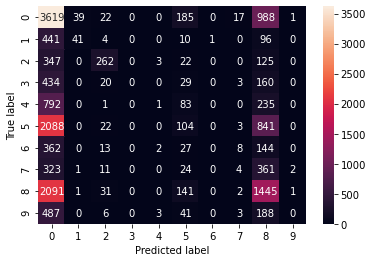

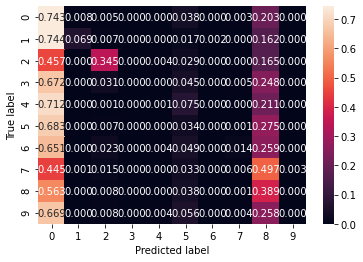

              precision    recall  f1-score   support

           0      0.329     0.743     0.457      4871
           1      0.500     0.069     0.121       593
           2      0.668     0.345     0.455       759
           3      0.000     0.000     0.000       646
           4      0.111     0.001     0.002      1112
           5      0.156     0.034     0.056      3058
           6      0.000     0.000     0.000       556
           7      0.100     0.006     0.010       726
           8      0.315     0.389     0.348      3712
           9      0.000     0.000     0.000       728

    accuracy                          0.327     16761
   macro avg      0.218     0.159     0.145     16761
weighted avg      0.254     0.327     0.246     16761



C:\Users\Gerardo\.conda\envs\capstone2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [229]:
confusion(ytest, ypred)

## t-SNE

In [262]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

[0 0 0 ... 6 8 5]


,MoreauBrotoAuto_ResidueASA27,MoreauBrotoAuto_ResidueASA26,MoreauBrotoAuto_ResidueASA25,MoreauBrotoAuto_ResidueASA24,MoreauBrotoAuto_ResidueASA23,MoreauBrotoAuto_ResidueASA22,MoreauBrotoAuto_ResidueASA21,MoreauBrotoAuto_ResidueASA20,MoreauBrotoAuto_ResidueASA29,MoreauBrotoAuto_ResidueASA28,...,GearyAuto_Steric19,GearyAuto_Steric18,GearyAuto_Steric13,GearyAuto_Steric12,GearyAuto_Steric11,GearyAuto_Steric10,GearyAuto_Steric17,GearyAuto_Steric16,GearyAuto_Steric15,GearyAuto_Steric14
0,-0.073,0.937,0.021,0.056,0.052,-0.013,-0.009,0.047,0.048,0.049,...,-0.143,0.991,-0.144,-0.142,-0.145,-0.144,-0.144,-0.148,-0.156,-0.148
1,0.183,1.145,-0.013,0.171,0.171,0.060,0.055,0.176,0.162,0.168,...,0.002,1.052,0.006,0.007,0.007,0.007,0.002,0.001,0.007,0.006
2,0.183,1.145,-0.013,0.171,0.171,0.060,0.055,0.176,0.162,0.168,...,0.002,1.052,0.006,0.007,0.007,0.007,0.002,0.001,0.007,0.006
3,-0.063,0.901,-0.073,-0.007,-0.001,0.042,0.042,0.004,0.009,0.005,...,0.016,0.932,0.012,0.011,0.012,0.013,0.017,0.012,0.014,0.013
4,-0.063,0.901,-0.073,-0.007,-0.001,0.042,0.042,0.004,0.009,0.005,...,0.016,0.932,0.012,0.011,0.012,0.013,0.017,0.012,0.014,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55862,-0.021,0.891,-0.003,0.085,0.089,-0.017,-0.018,0.088,0.090,0.091,...,-0.051,1.146,-0.051,-0.057,-0.059,-0.058,-0.052,-0.052,-0.052,-0.052
55863,-0.062,0.915,-0.074,0.001,0.008,0.044,0.043,0.012,0.017,0.013,...,0.021,0.931,0.017,0.016,0.017,0.018,0.022,0.016,0.018,0.018
55864,-0.027,0.880,-0.084,-0.018,-0.002,-0.131,-0.124,0.006,0.021,-0.000,...,-0.059,1.024,-0.061,-0.066,-0.065,-0.062,-0.059,-0.059,-0.058,-0.055
55865,0.043,1.069,-0.036,0.029,0.034,0.075,0.075,0.040,0.039,0.037,...,-0.012,1.022,-0.017,-0.030,-0.003,0.024,-0.012,-0.012,-0.013,-0.014


In [365]:
# Run PCA with 50 components

pca = PCA(n_components=81)
df_ML_50 = pd.DataFrame(
    pca.fit_transform(X1),
    columns = ['PC'+str(i+1) for i in range(pca.n_components)], 
    index   = X1.index)
# df_ML_50 = pca.fit_transform(digits.values)

print("Cumulative variance explained by first 50 Principal Components: {}".format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by first 50 Principal Components: 0.8137943274424336


In [363]:
X1

,MoreauBrotoAuto_ResidueASA27,MoreauBrotoAuto_ResidueASA26,MoreauBrotoAuto_ResidueASA25,MoreauBrotoAuto_ResidueASA24,MoreauBrotoAuto_ResidueASA23,MoreauBrotoAuto_ResidueASA22,MoreauBrotoAuto_ResidueASA21,MoreauBrotoAuto_ResidueASA20,MoreauBrotoAuto_ResidueASA29,MoreauBrotoAuto_ResidueASA28,...,GearyAuto_Steric19,GearyAuto_Steric18,GearyAuto_Steric13,GearyAuto_Steric12,GearyAuto_Steric11,GearyAuto_Steric10,GearyAuto_Steric17,GearyAuto_Steric16,GearyAuto_Steric15,GearyAuto_Steric14
0,-0.073,0.937,0.021,0.056,0.052,-0.013,-0.009,0.047,0.048,0.049,...,-0.143,0.991,-0.144,-0.142,-0.145,-0.144,-0.144,-0.148,-0.156,-0.148
1,0.183,1.145,-0.013,0.171,0.171,0.060,0.055,0.176,0.162,0.168,...,0.002,1.052,0.006,0.007,0.007,0.007,0.002,0.001,0.007,0.006
2,0.183,1.145,-0.013,0.171,0.171,0.060,0.055,0.176,0.162,0.168,...,0.002,1.052,0.006,0.007,0.007,0.007,0.002,0.001,0.007,0.006
3,-0.063,0.901,-0.073,-0.007,-0.001,0.042,0.042,0.004,0.009,0.005,...,0.016,0.932,0.012,0.011,0.012,0.013,0.017,0.012,0.014,0.013
4,-0.063,0.901,-0.073,-0.007,-0.001,0.042,0.042,0.004,0.009,0.005,...,0.016,0.932,0.012,0.011,0.012,0.013,0.017,0.012,0.014,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55862,-0.021,0.891,-0.003,0.085,0.089,-0.017,-0.018,0.088,0.090,0.091,...,-0.051,1.146,-0.051,-0.057,-0.059,-0.058,-0.052,-0.052,-0.052,-0.052
55863,-0.062,0.915,-0.074,0.001,0.008,0.044,0.043,0.012,0.017,0.013,...,0.021,0.931,0.017,0.016,0.017,0.018,0.022,0.016,0.018,0.018
55864,-0.027,0.880,-0.084,-0.018,-0.002,-0.131,-0.124,0.006,0.021,-0.000,...,-0.059,1.024,-0.061,-0.066,-0.065,-0.062,-0.059,-0.059,-0.058,-0.055
55865,0.043,1.069,-0.036,0.029,0.034,0.075,0.075,0.040,0.039,0.037,...,-0.012,1.022,-0.017,-0.030,-0.003,0.024,-0.012,-0.012,-0.013,-0.014


In [359]:
# Run t-SNE
from sklearn.manifold import TSNE

df_ML_50_1 = df_ML_50.iloc[:20000,:]

digits_tsne = TSNE(
    n_components=2, 
    perplexity=40, 
    verbose=2).fit_transform(df_ML_50_1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.609s...
[t-SNE] Computed neighbors for 20000 samples in 54.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

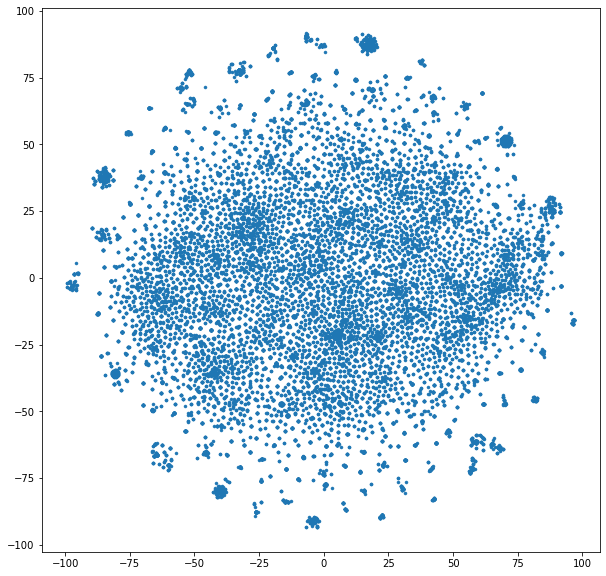

In [360]:
def plot_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5, 
    )
    plt.show()

labels = pd.DataFrame()
labels["TSNE1"] = digits_tsne[:,0]
labels["TSNE2"] = digits_tsne[:,1]
labels['ground_truth'] = y[:20000]
plot_tsne(labels)

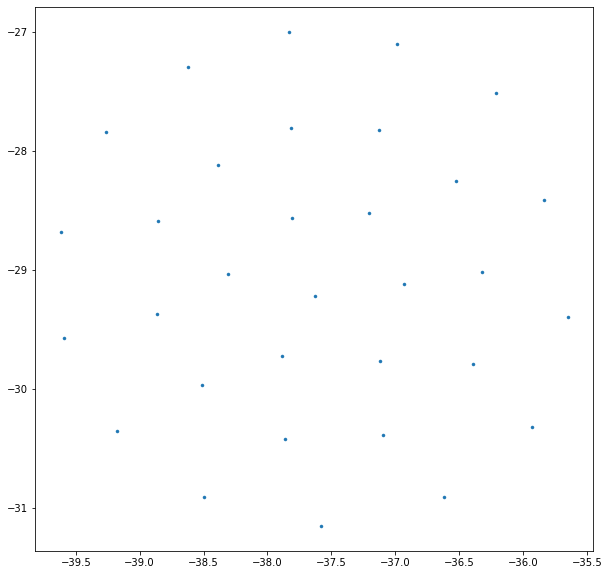

In [347]:
-41, -35   -25, -35
ciao = pd.DataFrame(digits_tsne)
sorte = ciao[(ciao[0] >=-41) & (ciao[0] <=-35) & (ciao[1] >=-35) & (ciao[1] <=-25)]
fig = plt.figure(figsize=(10, 10))
plt.scatter(
        sorte[0].values, 
        sorte[1].values,
        marker='.', 
        linewidths=0.5)

plt.show()

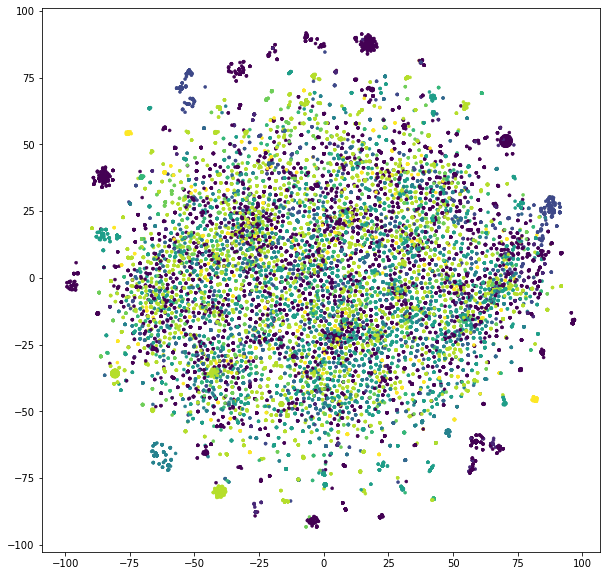

In [361]:
# Plot the results with points coloured by digit
def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

plot_coloured_tsne(labels) #[labels.ground_truth==0])

In [322]:
df_ML.groupby(['classification']).count()

,structureId,structureMolecularWeight,phValue,sequence,MoreauBrotoAuto_ResidueASA27,MoreauBrotoAuto_ResidueASA26,MoreauBrotoAuto_ResidueASA25,MoreauBrotoAuto_ResidueASA24,MoreauBrotoAuto_ResidueASA23,MoreauBrotoAuto_ResidueASA22,...,GearyAuto_Steric19,GearyAuto_Steric18,GearyAuto_Steric13,GearyAuto_Steric12,GearyAuto_Steric11,GearyAuto_Steric10,GearyAuto_Steric17,GearyAuto_Steric16,GearyAuto_Steric15,GearyAuto_Steric14
classification,,,,,,,,,,,,,,,,,,,,,
HYDROLASE,16236,16236,16236,16236,16236,16236,16236,16236,16236,16236,...,16236,16236,16236,16236,16236,16236,16236,16236,16236,16236
HYDROLASE/HYDROLASE INHIBITOR,1977,1977,1977,1977,1977,1977,1977,1977,1977,1977,...,1977,1977,1977,1977,1977,1977,1977,1977,1977,1977
IMMUNE SYSTEM,2529,2529,2529,2529,2529,2529,2529,2529,2529,2529,...,2529,2529,2529,2529,2529,2529,2529,2529,2529,2529
ISOMERASE,2153,2153,2153,2153,2153,2153,2153,2153,2153,2153,...,2153,2153,2153,2153,2153,2153,2153,2153,2153,2153
LYASE,3708,3708,3708,3708,3708,3708,3708,3708,3708,3708,...,3708,3708,3708,3708,3708,3708,3708,3708,3708,3708
OXIDOREDUCTASE,10193,10193,10193,10193,10193,10193,10193,10193,10193,10193,...,10193,10193,10193,10193,10193,10193,10193,10193,10193,10193
SIGNALING PROTEIN,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852,...,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852
TRANSCRIPTION,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421,...,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421
TRANSFERASE,12372,12372,12372,12372,12372,12372,12372,12372,12372,12372,...,12372,12372,12372,12372,12372,12372,12372,12372,12372,12372


### To plot the Moran descriptors only

it seems the Moran MoreauBroto and Geary descriptors are highly correlated between them

In [ ]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

df_descriptors = pd.read_csv(r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv")

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

X, y = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
X1

In [414]:
columns_to_investigate = [item for item in X1.columns if "Moran" in item]

In [425]:
pca = PCA(n_components= 80)  #len(columns_to_investigate))
df_ML_50_moran = pd.DataFrame(
    pca.fit_transform(X1[columns_to_investigate]),
    columns = ['PC'+str(i+1) for i in range(pca.n_components)], 
    index   = X1.index) #X1.iloc[:,:11].index)
# df_ML_50 = pca.fit_transform(digits.values)

print("Cumulative variance explained by first 80 Principal Components: {}".format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by first 80 Principal Components: 0.8976948151779451


In [ ]:
loadings = pd.DataFrame(pca.components_, 
                        columns = columns_to_investigate,   #X1.columns[:11],
                        index = df_ML_50_moran.columns)
plt.figure(figsize=(20, 16))
sns.heatmap(
        loadings.transpose(), 
        linewidths=0.5, 
        cmap="RdBu", 
        vmin=-1, vmax=1, annot=True )

    Explained Var  Cumulative Var
0       18.046563       18.046563
1        6.036268       24.082831
2        4.975701       29.058532
3        3.801975       32.860507
4        3.101029       35.961536
..            ...             ...
75       0.292501       88.639487
76       0.288144       88.927631
77       0.284584       89.212215
78       0.280318       89.492533
79       0.276948       89.769482

[80 rows x 2 columns]


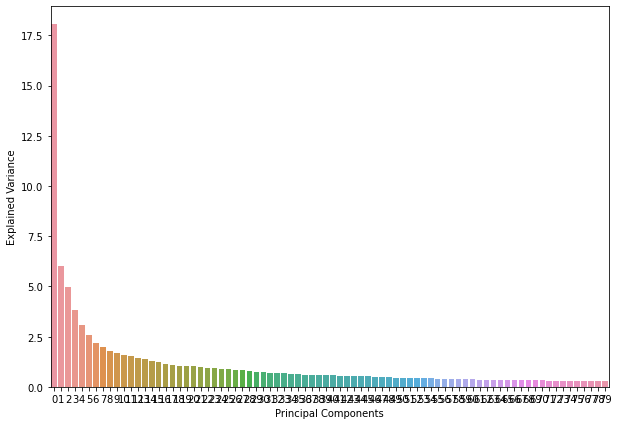

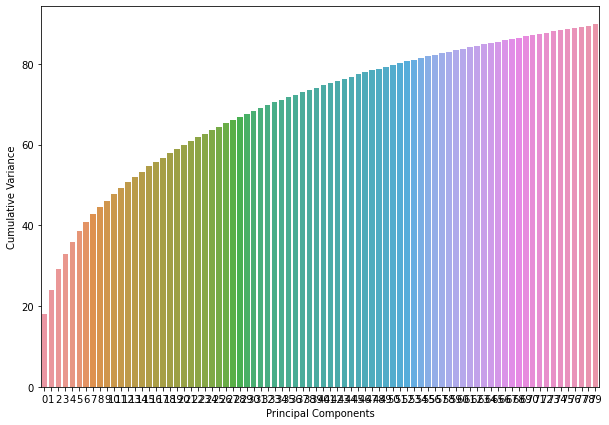

In [428]:
variance_data(pca)

In [430]:
# Run t-SNE
from sklearn.manifold import TSNE

df_ML_50_moran_tsne = df_ML_50_moran.iloc[:20000,:]

digits_tsne = TSNE(
    n_components=2, 
    perplexity=40, 
    verbose=2).fit_transform(df_ML_50_moran_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.567s...
[t-SNE] Computed neighbors for 20000 samples in 91.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

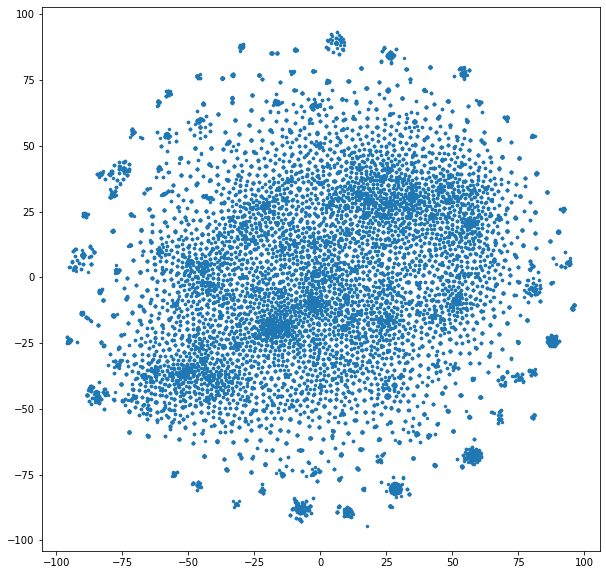

In [436]:
def plot_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5, 
    )
    plt.show()

labels = pd.DataFrame()
labels["TSNE1"] = digits_tsne[:,0]
labels["TSNE2"] = digits_tsne[:,1]
labels['ground_truth'] = y[:20000]
plot_tsne(labels)

Plot coloured with the labels

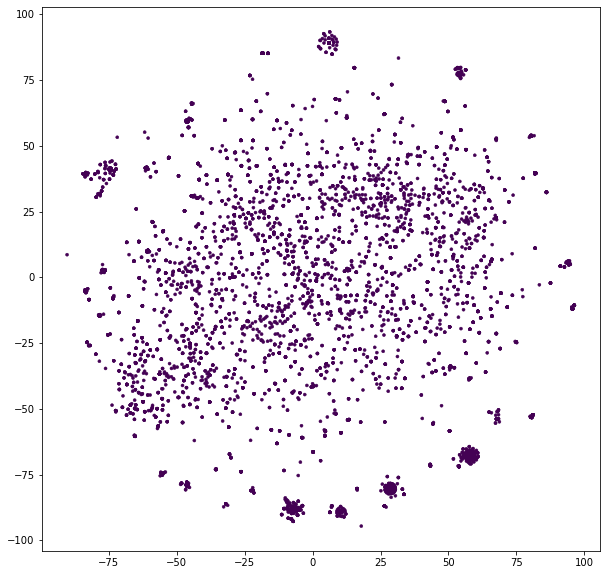

In [448]:
# Plot the results with points coloured by digit
def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

plot_coloured_tsne(labels[labels.ground_truth==0])